# Additional examples
Author: Audrey Olivier, 03-10-2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Examples where the model takes in some fixed parameters

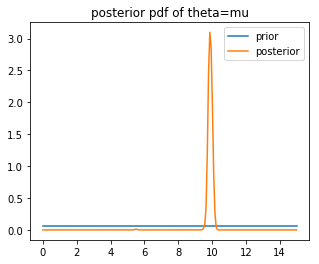

In [2]:
np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data_1 = np.random.normal(mu, sigma, 100)
np.random.seed()

# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', n_params=1,
                        prior_name = ['uniform'], 
                        prior_params = [[0, 15]], fixed_params=[1])

# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data_1, sampling_method = 'MCMC', nsamples=500, 
                                           pdf_proposal = 'Normal', pdf_proposal_scale=[1], 
                                           model=candidate_model, 
                                           algorithm = 'MH', jump=10, nburn=10, 
                                           seed=np.array([1.0]))

fig, ax = plt.subplots(1,1, figsize=(5,4))
s = bayes_estimator.samples
domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax.plot(domain, Distribution('uniform').pdf(domain, [0,15]), label='prior')
ax.plot(domain, np.exp(log_dens), label='posterior')
ax.set_title('posterior pdf of theta=mu')
ax.legend()

plt.show()

(1, 2)
[1.41227454e-01 1.48949003e+00 2.05550489e+00 2.04654898e+00
 4.36984839e+00 4.57358278e+00 8.46123427e+00 7.39161113e+00
 1.04364795e+01 1.18823653e+01 1.35010934e+01 1.57989189e+01
 1.98672683e+01 2.32123341e+01 2.49576567e+01 2.73385088e+01
 2.95205034e+01 3.47000626e+01 3.66559754e+01 4.12865623e+01
 4.72939191e+01 4.98639568e+01 5.20505761e+01 5.78720102e+01
 6.28877756e+01 6.68041746e+01 7.26186485e+01 7.84267350e+01
 8.17770939e+01 8.65612933e+01 9.32403340e+01 9.99933070e+01
 1.04722821e+02 1.12579416e+02 1.15032692e+02 1.23149132e+02
 1.29538561e+02 1.38003391e+02 1.43137842e+02 1.49816721e+02
 1.57324712e+02 1.65236217e+02 1.71855742e+02 1.79415059e+02
 1.89023879e+02 1.95663823e+02 2.02966882e+02 2.12732327e+02
 2.20711487e+02 2.28470028e+02]


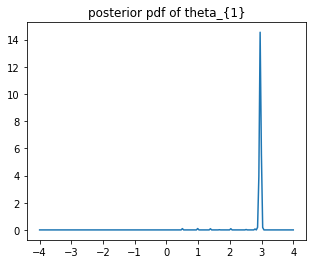

In [3]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([3.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_0', 'theta_1'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

candidate_model = Model(n_params=1, model_type='python', 
                        model_script='pfn_models.py', model_object_name = 'model_quadratic',
                        error_covariance=error_covariance, fixed_params=[2.0])

bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, 
                                           sampling_method = 'MCMC', nsamples=500,
                                           algorithm = 'MH', jump=10, nburn=0, 
                                           pdf_proposal = 'Normal',
                                           pdf_proposal_scale = [0.1], seed = [0.5])

s = bayes_estimator.samples
fig, ax = plt.subplots(1,1, figsize=(5,4))

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax.plot(domain, pdf_, label='posterior')
ax.set_title('posterior pdf of theta_{1}')
plt.show()

## Examples where the noise covariance is learnt along with the model parameters

In [4]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_models.py', model_object_name = 'model_quadratic', 
             var_names = ['theta_0', 'theta_1'])
data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[ -1.79442496   2.05238156   1.22704169  -0.42737846   3.04081646
   3.48661949   4.55446695   6.25566869   7.3551542    9.57331275
  10.14669254  12.60606971  15.39127498  18.30949147  18.7386345
  21.58648111  25.22421428  27.7870223   31.07529097  35.26624975
  36.10309322  42.05588663  43.52946147  47.83216667  53.84088182
  57.54549601  60.64072149  67.31139189  68.96930992  75.12109184
  81.76311031  84.39122794  92.33472356  98.67649506 101.9657527
 109.33321364 113.58214603 121.85815419 129.1769438  135.06512371
 142.18298042 147.63326147 156.64962094 162.91516624 172.17978088
 180.02473571 187.43990682 193.40483338 200.97138419 210.99219828]


In [5]:
model = Model(n_params=2, model_type='python', 
              model_script='pfn_models.py', model_object_name = 'model_quadratic',
              error_adapt=True, prior_error_name='lognormal', 
              prior_error_params=[1, 0, 1])

In [6]:
be = BayesParameterEstimation(data=data, model=model, sampling_method = 'MCMC', 
                              nsamples=2000,
                              algorithm = 'MH', jump=20, nburn=100, pdf_proposal = 'Normal',
                              pdf_proposal_scale = [0.1, 0.05, 0.025])

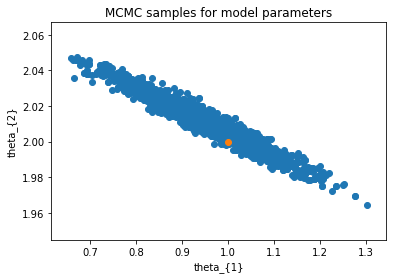

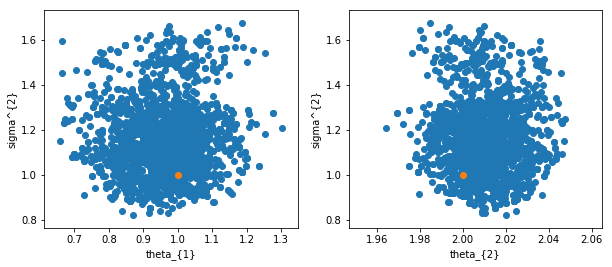

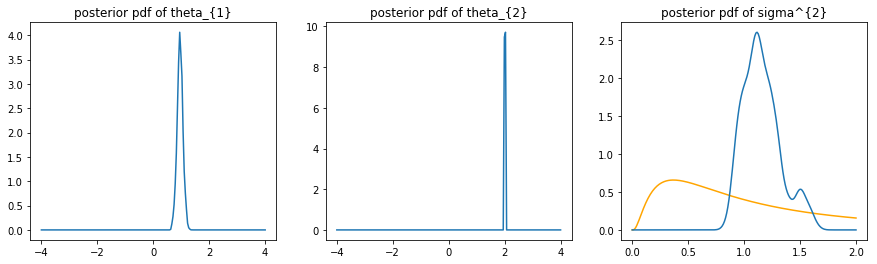

In [7]:
s = be.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples for model parameters')
plt.xlabel('theta_{1}')
plt.ylabel('theta_{2}')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(s[:,0],s[:,2])
ax[0].scatter(1.0, 1.0, label='true value')
ax[0].set_xlabel('theta_{1}')
ax[0].set_ylabel('sigma^{2}')
ax[1].scatter(s[:,1],s[:,2])
ax[1].scatter(2.0, 1.0, label='true value')
ax[1].set_xlabel('theta_{2}')
ax[1].set_ylabel('sigma^{2}')

plt.show()

fig, ax = plt.subplots(1,3, figsize=(15,4))

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='posterior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='posterior')
ax[1].set_title('posterior pdf of theta_{2}')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
prior_sig2 = model.prior_error
pdf_ = prior_sig2.pdf(x=domain, params=model.prior_error_params)
ax[2].plot(domain, pdf_, label='prior', color='orange')
kde = KDEUnivariate(s[:,2])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[2].plot(domain, pdf_, label='posterior')
ax[2].set_title('posterior pdf of sigma^{2}')

plt.show()